# Tutorial: z-Axis detection of (simulated) glass beads

Having tested the model on spots, we now want to assess the performance using a reference stack of glass beads provided by the Taute Lab

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
import ultralytics

import matplotlib.patches as patches
from matplotlib import colormaps as cmaps
import os
from tqdm import tqdm
import yaml
from importlib import reload  # Python 3.4+
import pandas as pd

import image_generator as ig

from yundon_functions import *
pi = np.pi
from multiprocessing import Pool
from PIL import Image
from cv2 import resize
from itertools import repeat
from matplotlib.patches import Rectangle, Circle
# %matplotlib widget
import cv2
from ultralytics.utils import ops
from YOLOtrack11 import YOLOtrack11
from scipy.stats import binned_statistic

def plot_result(ax,img,objects, vmin=1.95e4, vmax=2.05e4):
    if isinstance(img, PIL.Image.Image) or isinstance(img, np.ndarray):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for i,obj in objects.iterrows():
        l,x,y,w,h = obj[:5]
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
        tx,ty = rect.get_xy()
        ax.add_patch(rect)
        tx+=6
        ty-=12
        circle = Circle((x,y),1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)
        if l == "Ripple":
            ax.text(tx,ty,f"{obj["z"]*0.134:.3f}",fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

def plot_result_old(ax,img,cls,bboxes=repeat(None),z=None,kpts=None, conf=None,vmin=1.95e4,vmax=2.05e4):
    is_conf = conf is not None
    if not is_conf:
         conf = np.zeros_like(cls)
    if isinstance(img, PIL.Image.Image):
        pass
    elif(type(img) == str):
        img = PIL.Image.open(img)
    ax.imshow(img,cmap="grey",vmin=vmin,vmax=vmax)
    ax.axis("off")
    for bbox,z_value,kpt,c in zip(bboxes, z, kpts,conf):
        if(bbox is not None):
            x,y,w,h = bbox
            rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="yellow", facecolor='none')
            tx,ty = rect.get_xy()
            ax.add_patch(rect)
            tx+=6
            ty-=12
        else:
            tx,ty = kpt
            ty-=40
            tx-=50
        circle = Circle(kpt,1, facecolor="red",edgecolor="red")
        ax.add_patch(circle)

        ax.text(tx,ty,f"z={z_value:.3f}" + (f", {c*100:.0f}%" if is_conf else ""),fontsize="small",bbox=dict(facecolor='white', alpha=0.5,))

    return bboxes

def plot_gt(path,ax,imgsz=[512,512],vmin=1.95e4,vmax=2.05e4):
    data=np.atleast_2d(np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt"))).T
    # print(data)
    if(len(data)==0):
         return plot_result_old(ax,path, np.empty(0),np.empty((0,4)),np.empty(0),np.empty((0,0)),vmin=vmin,vmax=vmax)
    cls = data[0]
    bboxes = data[1:5].T*(imgsz*2)
    z = data[5]
    kpts = data[7:].T*imgsz
    # print(bboxes)
    
    return plot_result_old(ax,path, cls,bboxes,z,kpts, vmin=vmin,vmax=vmax)

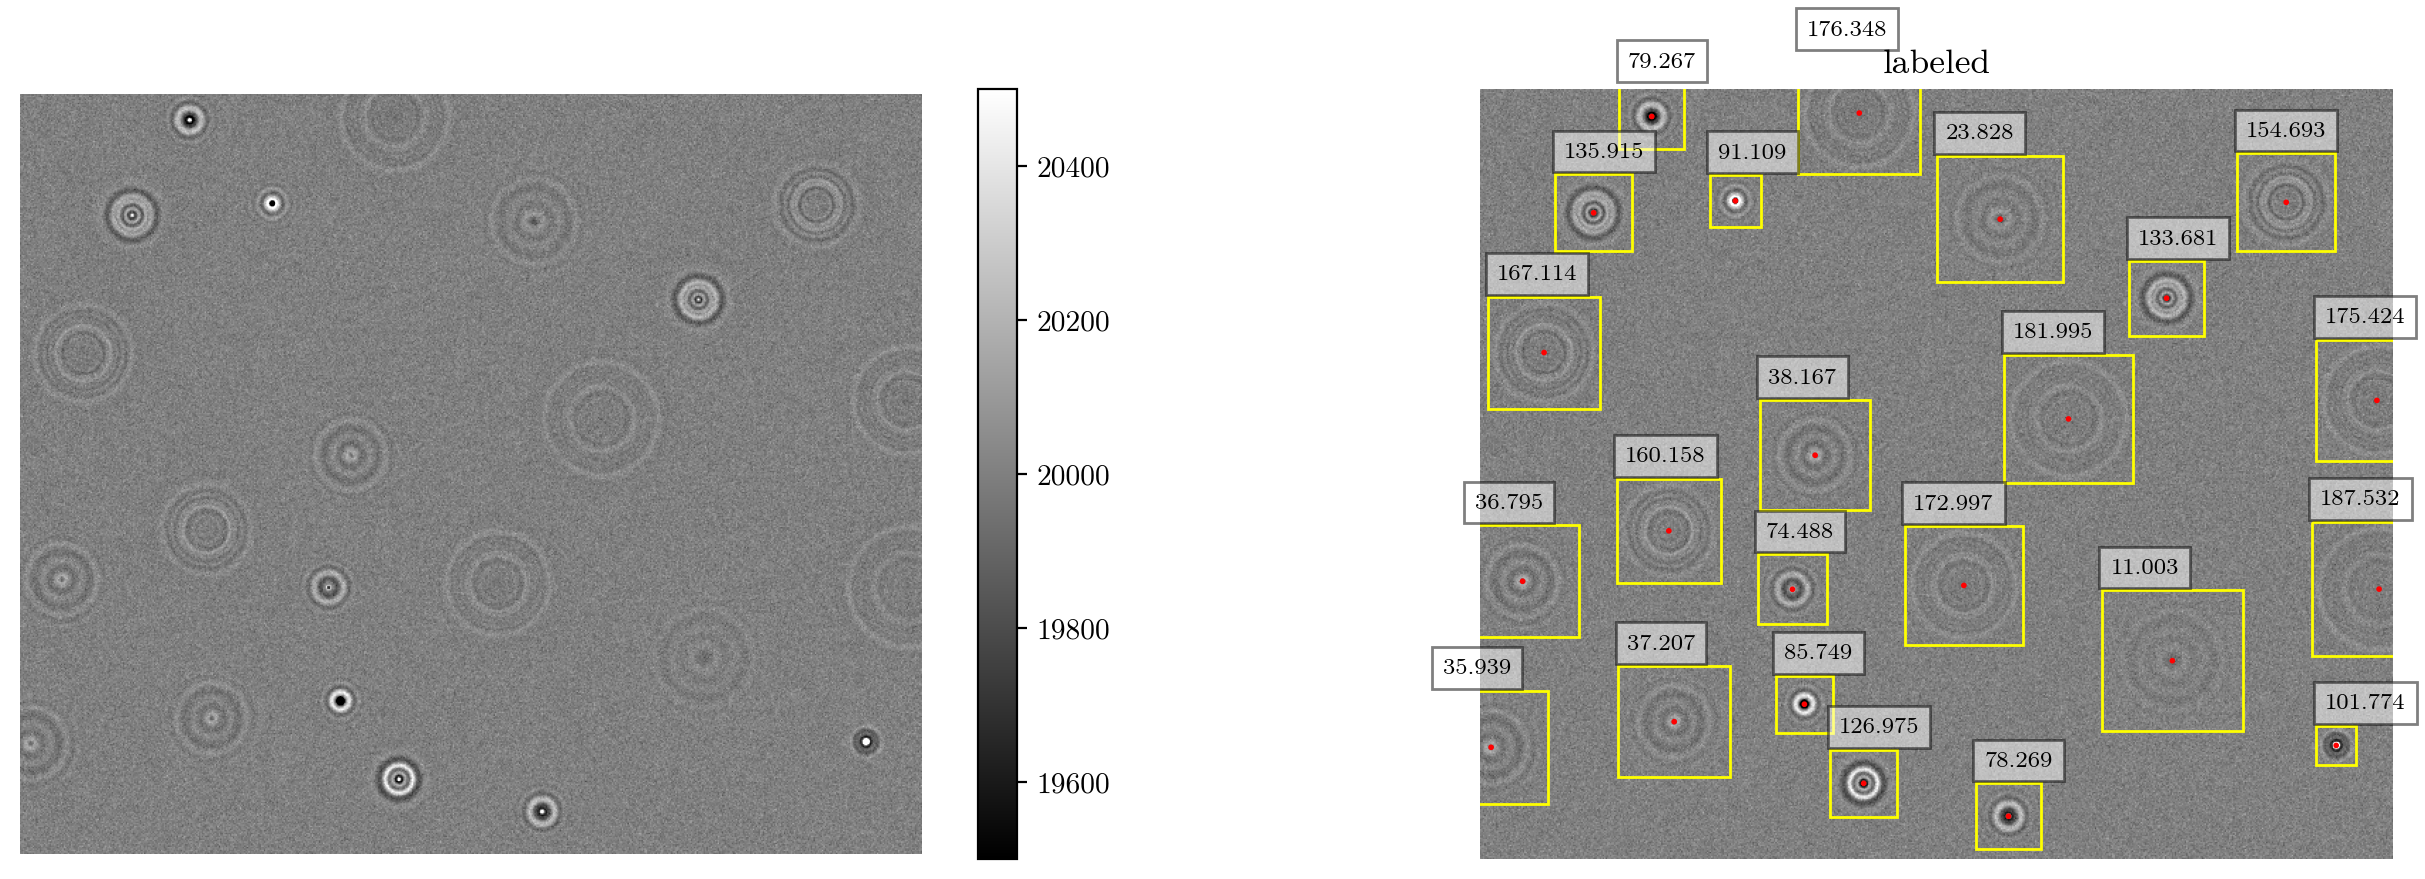

In [32]:
ripple_params = {"label":"Ripple",  "z":[0,1567], "i":1, "n":(20,30)}
parameter_list = [ripple_params]
reload(ig)
# Load the downsampled reference stack
downsampled_refstack = (np.load("../ripples_downsampled.npy"))-2e4 # shape (1568, 128, 128)
x0, y0 = 64.4, 63.7 # Center of the reference stack


image_size = 540,640       # Dimension 
distance = 0               # Min distance between points
no_overlap = True
offset = 0                 # Boundary padding
noise = [47,47]      # This time, we use an absolute noise, since the SNR cannot be defined for the whole image, it is dependent on the z position

objects = ig.getRandom(parameter_list, image_size, distance=distance,distance_consider_object_size=no_overlap, offset=offset)

plt.close("all")

plt.figure(figsize=(16,5))
image,_ = ig.generateImage(objects, image_size, refstack=downsampled_refstack, refstack_center=(y0,x0),noise=noise, background=2e4)
ax = plt.subplot(1,2,1)
ax.axis("off")
plt.imshow(image, cmap="grey",vmin=1.95e4,vmax=2.05e4)
plt.colorbar()

ax = plt.subplot(1,2,2)
plt.title("labeled")
plot_result(ax,image,objects)
ax.axis("off")

# plt.tight_layout()
plt.show()


Now, let's generate some training data!

In [ ]:
subdir = '../datasets/Dataset_ripples/'
nimages = [25000,10000,1000]
folders = ["train_no_overlap","val_no_overlap_slow", "val_no_overlap_fast"]

import time
reload(ig)
if not os.path.exists(subdir):
    os.mkdir(subdir)

l_dir = subdir  + 'labels'
i_dir = subdir + 'images'
if not os.path.exists(i_dir):
    os.mkdir(i_dir)
if not os.path.exists(l_dir):
    os.mkdir(l_dir)
for i, prefix in enumerate(folders):
    image_dir = i_dir + '/' + prefix + '/'
    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    label_dir = l_dir + '/' + prefix + '/'
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)
for i, prefix in enumerate(folders):
    vectorized_index = np.vectorize(lambda labels,item: labels.index(item))
    rngs = []
    def init():
        # Initialize the random number generator for each process
        global rng #the rng variable is global so that it can be used in the call function
        rng = np.random.default_rng()
        time.sleep(rng.uniform(0,2))
    def call(j):
        labelname = l_dir + '/' + prefix + '/' + 'image_{:05d}.txt'.format(j,2)    
        fname = i_dir + '/' + prefix + '/' + 'image_{:05d}.tif'.format(j,2)

        for _ in range(20):
            try:
                objects = ig.getRandom(parameter_list, image_size, rng=rng, distance=distance, distance_consider_object_size=no_overlap, offset=offset)
                break
            except RuntimeError:
                continue
        else:
            raise RuntimeError("couldn't find object placement after 10 tries")


        if(len(objects) == 0):
            f = open(labelname, "w")
            f.write("\n")
            f.close()
            return

        image, info_dict = ig.generateImage(objects, image_size , noise=noise, rng=rng, refstack=downsampled_refstack, refstack_center=(y0,x0))
        image = (image).astype(np.uint16) #cast image to 16 bit uint for tiff
        image = Image.fromarray(image).save(fname, quality=100)

        objects[["x","w"]] /= image_size[1] # scale x and w to [0,1]
        objects[["y","h"]] /= image_size[0] # scale y and h to [0,1]

        objects["z"] = (objects["z"]-761)*0.134 

        # turn label into int:
        objects["label"]=pd.factorize(objects["label"])[0]

        # add keypoint coordinates
        objects[["kpt_x", "kpt_y"]] = objects[["x", "y"]]

        np.savetxt(labelname, objects.values, fmt='%g')# label x y w h z i x y
    with Pool(initializer=init) as pool:
        for _ in tqdm(pool.imap_unordered(call,range(nimages[i])),total=nimages[i], desc=prefix):
            pass
    global rng
    rng = np.random.default_rng()

val_no_overlap: 100%|██████████| 1000/1000 [00:04<00:00, 208.00it/s]


generate the corresponding yaml files

In [42]:
subdir = '../datasets/Dataset_ripples/'

file_path = '../datasets/ripples_fast.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_fast"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 2
dict['nc'] = 1
dict['names'] = ["Spot"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

file_path = '../datasets/ripples_slow.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_slow"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 2
dict['nc'] = 1
dict['names'] = ["Spot"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

file_path = '../datasets/ripples_no_overlap_fast.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train_no_overlap"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_no_overlap_fast"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 2
dict['nc'] = 1
dict['names'] = ["Spot"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)

file_path = '../datasets/ripples_no_overlap_slow.yaml'

dict = {}

dict["train"]=os.getcwd() + '/' + subdir + "images/" + "train_no_overlap"
dict["val"]=os.getcwd() + '/' + subdir + "images/" + "val_no_overlap_slow"
dict["kpt_shape"] = [1,2]
dict["num_extra_parameters"] = 2
dict['nc'] = 1
dict['names'] = ["Spot"]

with open(file_path, 'w') as file:
    yaml.dump(dict, file, default_flow_style=True)



In [ ]:
from YOLOtrack11 import YOLOtrack11
model = YOLOtrack11("yolo11n-zaxis.yaml")
results = model.train(data="datasets/ripples_no_overlap_fast.yaml", imgsz=(640,540), epochs=50)#, z=5,freeze=22,box=0,cls=0,dfl=0,pose=0)
model.save("yolo11n_ripples_custom_level.pt")

New https://pypi.org/project/ultralytics/8.3.155 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
trainer: task=zaxis, mode=train, model=yolo11n-zaxis.yaml, data=datasets/ripples_no_overlap_fast.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=(640, 540), save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train243, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=False, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False,

train: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_ripples/labels/train_no_overlap.cache... 25000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25000/25000 [00:00<?, ?it/s]
val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_ripples/labels/val_no_overlap_fast.cache... 1000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1000/1000 [00:00<?, ?it/s]


WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in in the future.
optimizer: SGD(lr=0.005, momentum=0.937) with parameter groups 93 weight(decay=0.0), 106 weight(decay=0.0005), 105 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/jupyter-till/git/ultralytics/runs/zaxis/train243
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss zaxis_loss  pose_loss  kobj_loss  Instances       Size


       1/10      4.49G       3.64      3.637      4.222      283.4      90.36          0        388        640:  17%|█▋        | 266/1563 [00:14<01:12, 17.98it/s]


KeyboardInterrupt: 

## Testing the model on images generated with the Taute Lab refstack
<!-- 
How does the performance vary with the Signal to noise ratio?

The SNR for an image is defined as the average max signal $|I_i-I_{\mathrm{bg}}|$ of each particle $i$, divided by the noise standard deviation $\sigma_{\mathrm{noise}}$,

$$
SNR = \frac{1}{\sigma_{\mathrm{noise}}} \frac{1}{N} \sum_{i=1}^{N} \max|I_i-I_{\mathrm{bg}}|
$$

TODO: compare with no-overlap training data -->

In [3]:
model = YOLOtrack11("yolo11n_ripples_no_overlap.pt")
imgsz=640,540
dataset_path = "../datasets/Dataset_ripples/images/val_no_overlap_slow"
test_images = os.listdir(dataset_path)
random_image = lambda: dataset_path+"/"+test_images[np.random.randint(0,len(test_images))]


0: 544x640 29 Spots, 6.0ms
Speed: 6.1ms preprocess, 6.0ms inference, 11.3ms postprocess per image at shape (1, 3, 544, 640)


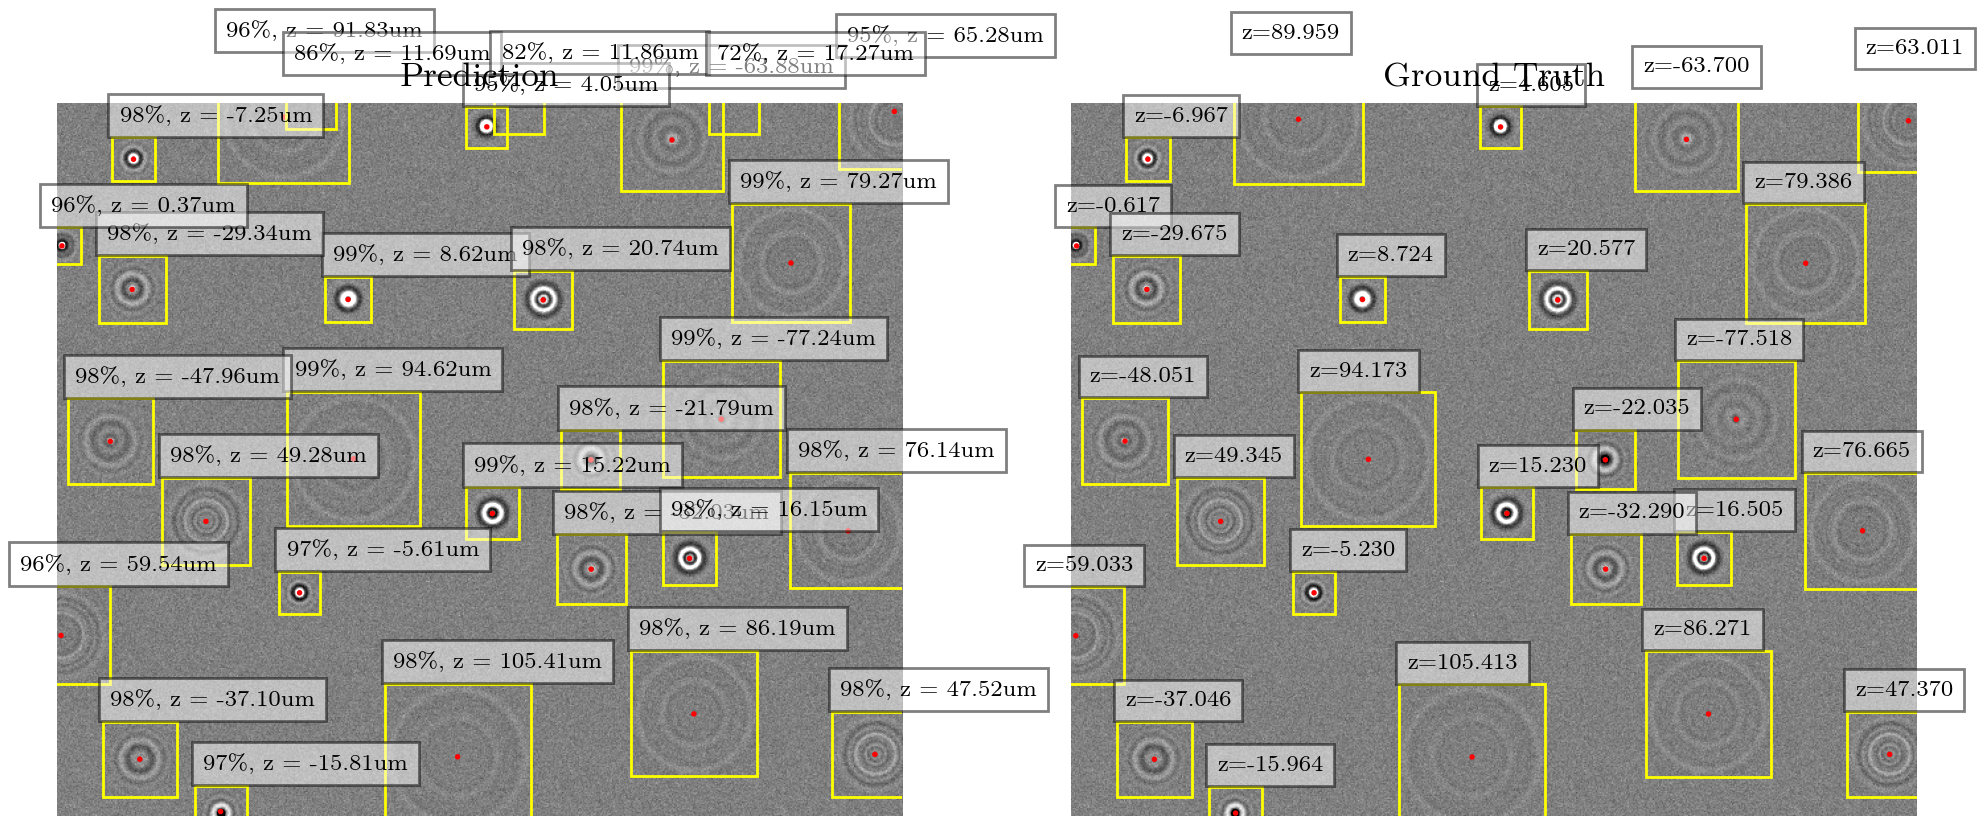

In [7]:
if not plt.get_fignums() : plt.figure(figsize=(12,5))
else: plt.clf()
image = random_image()
img = np.array(PIL.Image.open(image))
results = model.predict(np.array(img), conf = 0.7)
res = results[0].zaxis.data.cpu().numpy()
plt.subplot(1,2,1)
plt.title("Prediction")
# kpt = res[:,8:]
# bbox = res[:,:4]
# z = res[:,6]
# plot_result(plt.gca(),img,res[:,4],ops.xyxy2xywh(bbox),z,kpt,conf=res[:,4], vmin=1.95e4, vmax=2.05e4)
results[0].plot(plt.gca(),vmin=1.95e4, vmax=2.05e4)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")
plot_gt(image,plt.gca(),imgsz, vmin=1.95e4, vmax=2.05e4)
plt.show()



Let's evaluate the model on the "slow" validation set, containing 10000 images:

In [2]:

model_paths = "yolo11n_ripples_no_overlap.pt", "yolo11n_ripples.pt"
dataset_paths = "../datasets/ripples_no_overlap_slow.yaml", "../datasets/ripples_slow.yaml"
results = []
for model_path, dataset_path in zip(model_paths, dataset_paths):
    model = YOLOtrack11(model_path)
    res = model.val(data=dataset_path, workers=0, background=2e4, conf=0.8)
    results.append(res)


Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs
image size: 640


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_ripples/labels/val_no_overlap_slow.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:27<00:00, 22.94it/s]


                   all      10000     235792          1          1      0.995      0.995      0.424      0.229
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs
image size: 640


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_ripples/labels/val_slow.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:29<00:00, 21.23it/s]


                   all      10000     599713          1      0.987      0.993      0.991       1.19      0.492
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image


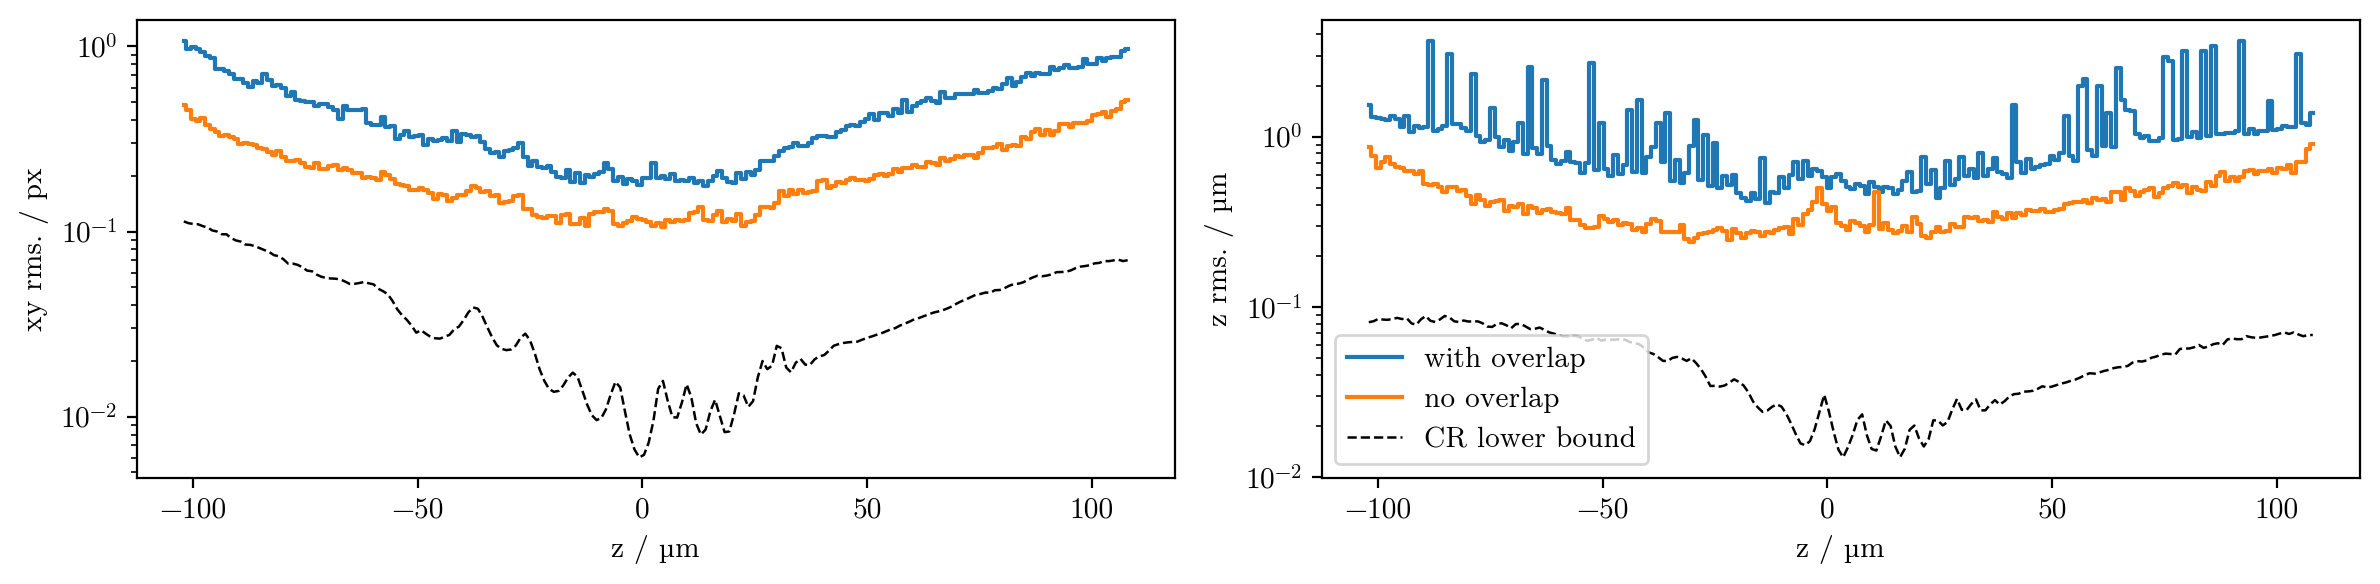

In [3]:

plt.figure(figsize=(12,3))
plt.subplot(121)
crlb = np.load("crlb_results.npz")
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)
crlb_xy = np.interp(z, crlb["z_space"], crlb["std_xy"])
k=10
crlb_z = np.interp(z, crlb["z_space"][k//2:-k//2:k], np.convolve(crlb["std_z"], np.ones(k)/k, mode='same')[k//2:-k//2:k])
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], results[1].xy_distances**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], results[0].xy_distances**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), where="mid")
# plt.hist(results[0].xyz_pairs[:,0,2], bins=bins_)
plt.plot(z, crlb_xy, "--", c="k", lw=0.9)
plt.yscale("log")
plt.xlabel("z / µm")
plt.ylabel("xy rms. / px")

plt.subplot(122)
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], np.subtract(*results[1].xyz_pairs[:,:,2].T)**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), label="with overlap", where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], np.subtract(*results[0].xyz_pairs[:,:,2].T)**2, bins=bins_, statistic=np.nanmean)
plt.step(z,np.sqrt(y), label="no overlap", where="mid")
k=10
plt.plot(z,crlb_z, "--", c="k", lw=0.9, label="CR lower bound")
plt.yscale("log")
plt.xlabel("z / µm")
plt.ylabel("z rms. / µm")
plt.legend()
# plt.ylim(0,7.5)
plt.tight_layout()

It seems strange that here, the CRLB is 1 order of magnitude below the model's rms.
We're in much better noise conditions compared to the spot images, so we are in the plateaued region (see previous chapter), where noise is no longer the limiting factor



To see if there are any systematic errors, let's look at the bias in x,y,z:

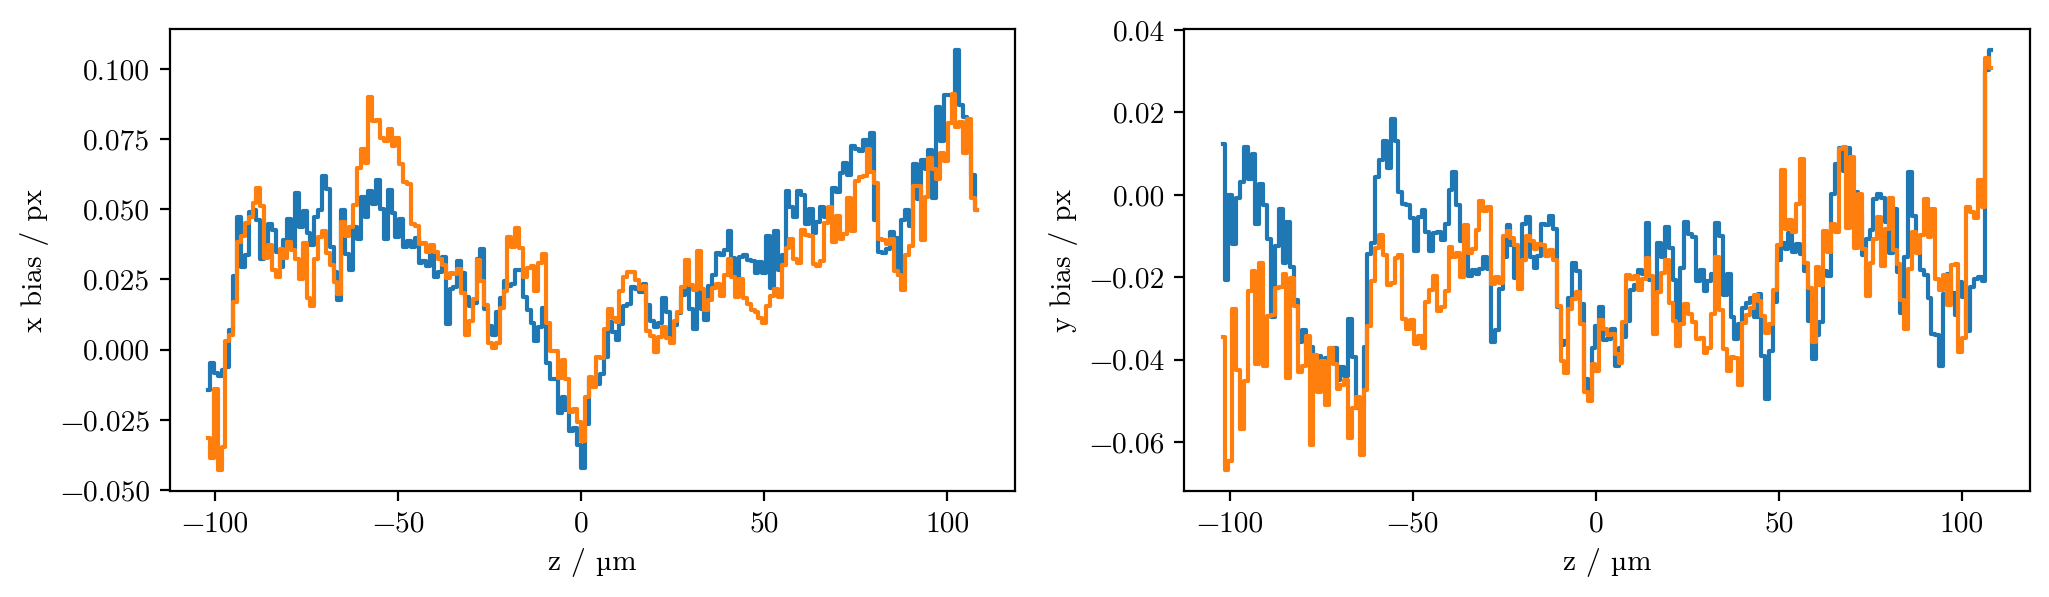

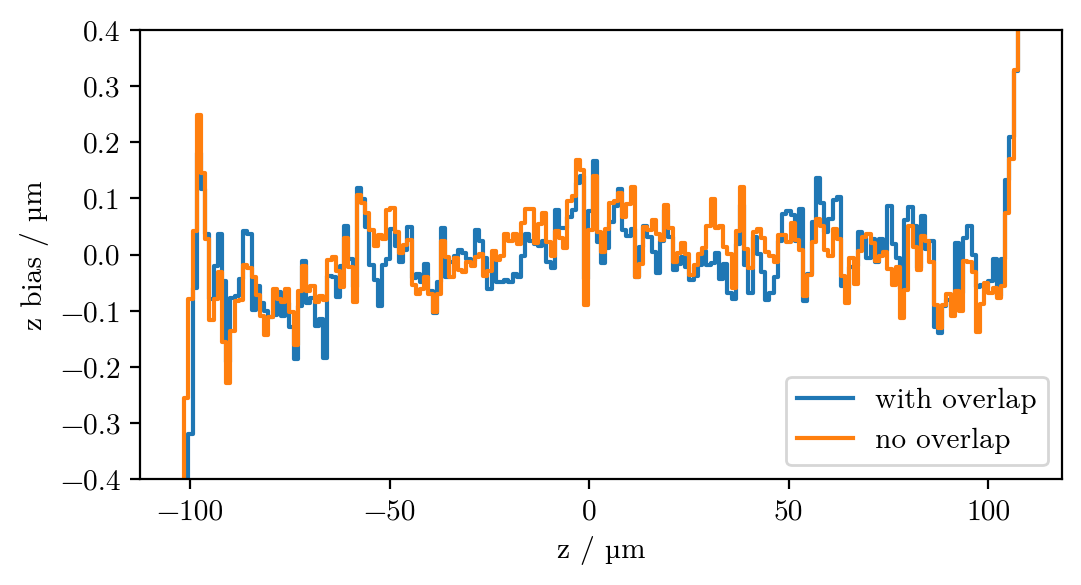

In [4]:
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)
plt.figure(figsize=(12,3))
plt.subplot(121)
z = np.linspace(-102,108,bins)
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], np.subtract(*results[1].xyz_pairs[:,:,0].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], np.subtract(*results[0].xyz_pairs[:,:,0].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid")
plt.xlabel("z / µm")
plt.ylabel("x bias / px")
plt.subplot(122)

y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], np.subtract(*results[0].xyz_pairs[:,:,1].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid", label="with overlap")
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], np.subtract(*results[1].xyz_pairs[:,:,1].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, where="mid", label="without overlap")
# plt.hist(results[0].xyz_pairs[:,0,2], bins=bins_, statistic=np.nanmean)
plt.xlabel("z / µm")
plt.ylabel("y bias / px")

plt.figure(figsize=(5.5,3))
y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], np.subtract(*results[1].xyz_pairs[:,:,2].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, label="with overlap", where="mid")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], np.subtract(*results[0].xyz_pairs[:,:,2].T), bins=bins_, statistic=np.nanmean)
plt.step(z,y, label="no overlap", where="mid")
plt.xlabel("z / µm")
plt.ylabel("z bias / µm")
plt.legend()
plt.ylim(-0.4,0.4)
plt.tight_layout()

Why do we see this pattern in the x bias?

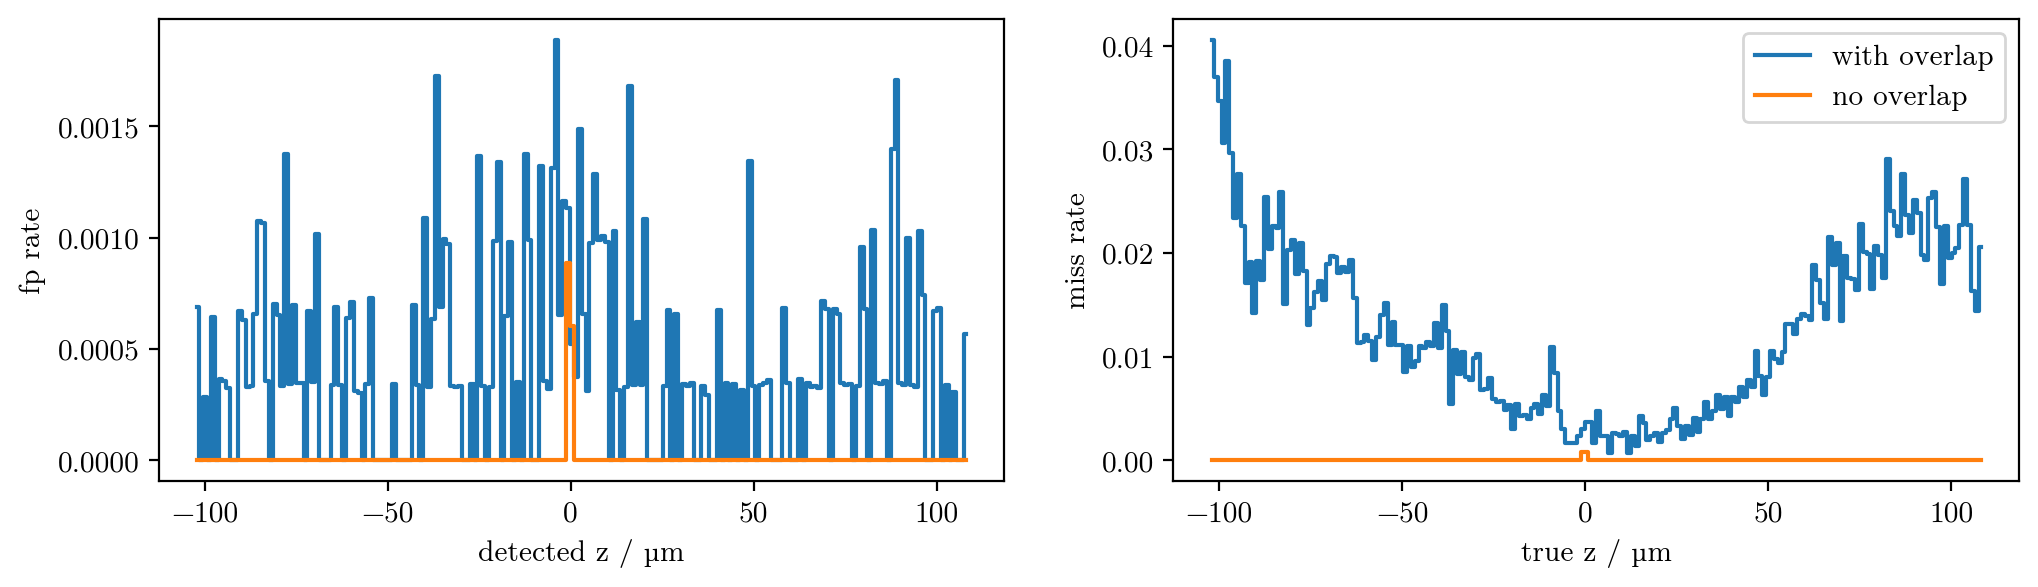

In [8]:
bins= 200
z = np.linspace(-102,108,bins)
bins_=np.linspace(-102,108,bins+1)

plt.figure(figsize=(12,3))
plt.subplot(121)
y, x,_ = binned_statistic(results[1].xyz_pairs[:,1,2], results[1].fp, bins=bins_)
plt.step(z,y, where="mid", label="with overlap")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,1,2], results[0].fp, bins=bins_)
plt.step(z,y, where="mid", label="no overlap")
plt.xlabel("detected z / µm")
plt.ylabel("fp rate")
plt.subplot(122)

y, x,_ = binned_statistic(results[1].xyz_pairs[:,0,2], results[1].fn, bins=bins_)
plt.step(z,y, where="mid", label="with overlap")
y, x,_ = binned_statistic(results[0].xyz_pairs[:,0,2], results[0].fn, bins=bins_)
plt.step(z,y, where="mid", label="no overlap")
plt.xlabel("true z / µm")
plt.ylabel("miss rate")
plt.legend()

## How does the performance vary with the training set size?



In [4]:
num = 5000,10000,20000,50000
model_idx = 163,159,161,162,122

results = []
for i,n in zip(model_idx,num):
    model = YOLOtrack11(f"../../ultralytics/runs/pose/train{i}/weights/last.pt")
    results.append(model.val(save=False, data=f'../datasets/snr10-13.yaml', workers=0, conf=0.8))


Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_subpixel/labels/val_snr10-13.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:24<00:00, 25.46it/s]


                   all      10000     603115       0.91      0.179      0.544      0.352       9.53       4.09
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_subpixel/labels/val_snr10-13.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:20<00:00, 30.36it/s]


                   all      10000     603115      0.996      0.726      0.862      0.773       4.31       2.01
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_subpixel/labels/val_snr10-13.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:20<00:00, 30.89it/s]


                   all      10000     603115      0.995      0.814      0.906      0.846       3.07       1.68
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Ultralytics 8.3.79 🚀 Python-3.12.6 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 4090, 24202MiB)
YOLO11n-zaxis summary (fused): 118 layers, 2,725,303 parameters, 0 gradients, 6.7 GFLOPs


val: Scanning /home/jupyter-till/git/YOLOTrack11/datasets/Dataset_subpixel/labels/val_snr10-13.cache... 10000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10000/10000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     z rms.    xy rms.: 100%|██████████| 625/625 [00:19<00:00, 31.29it/s]


                   all      10000     603115      0.989       0.88      0.938      0.903       4.21       1.44
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 0.2ms postprocess per image


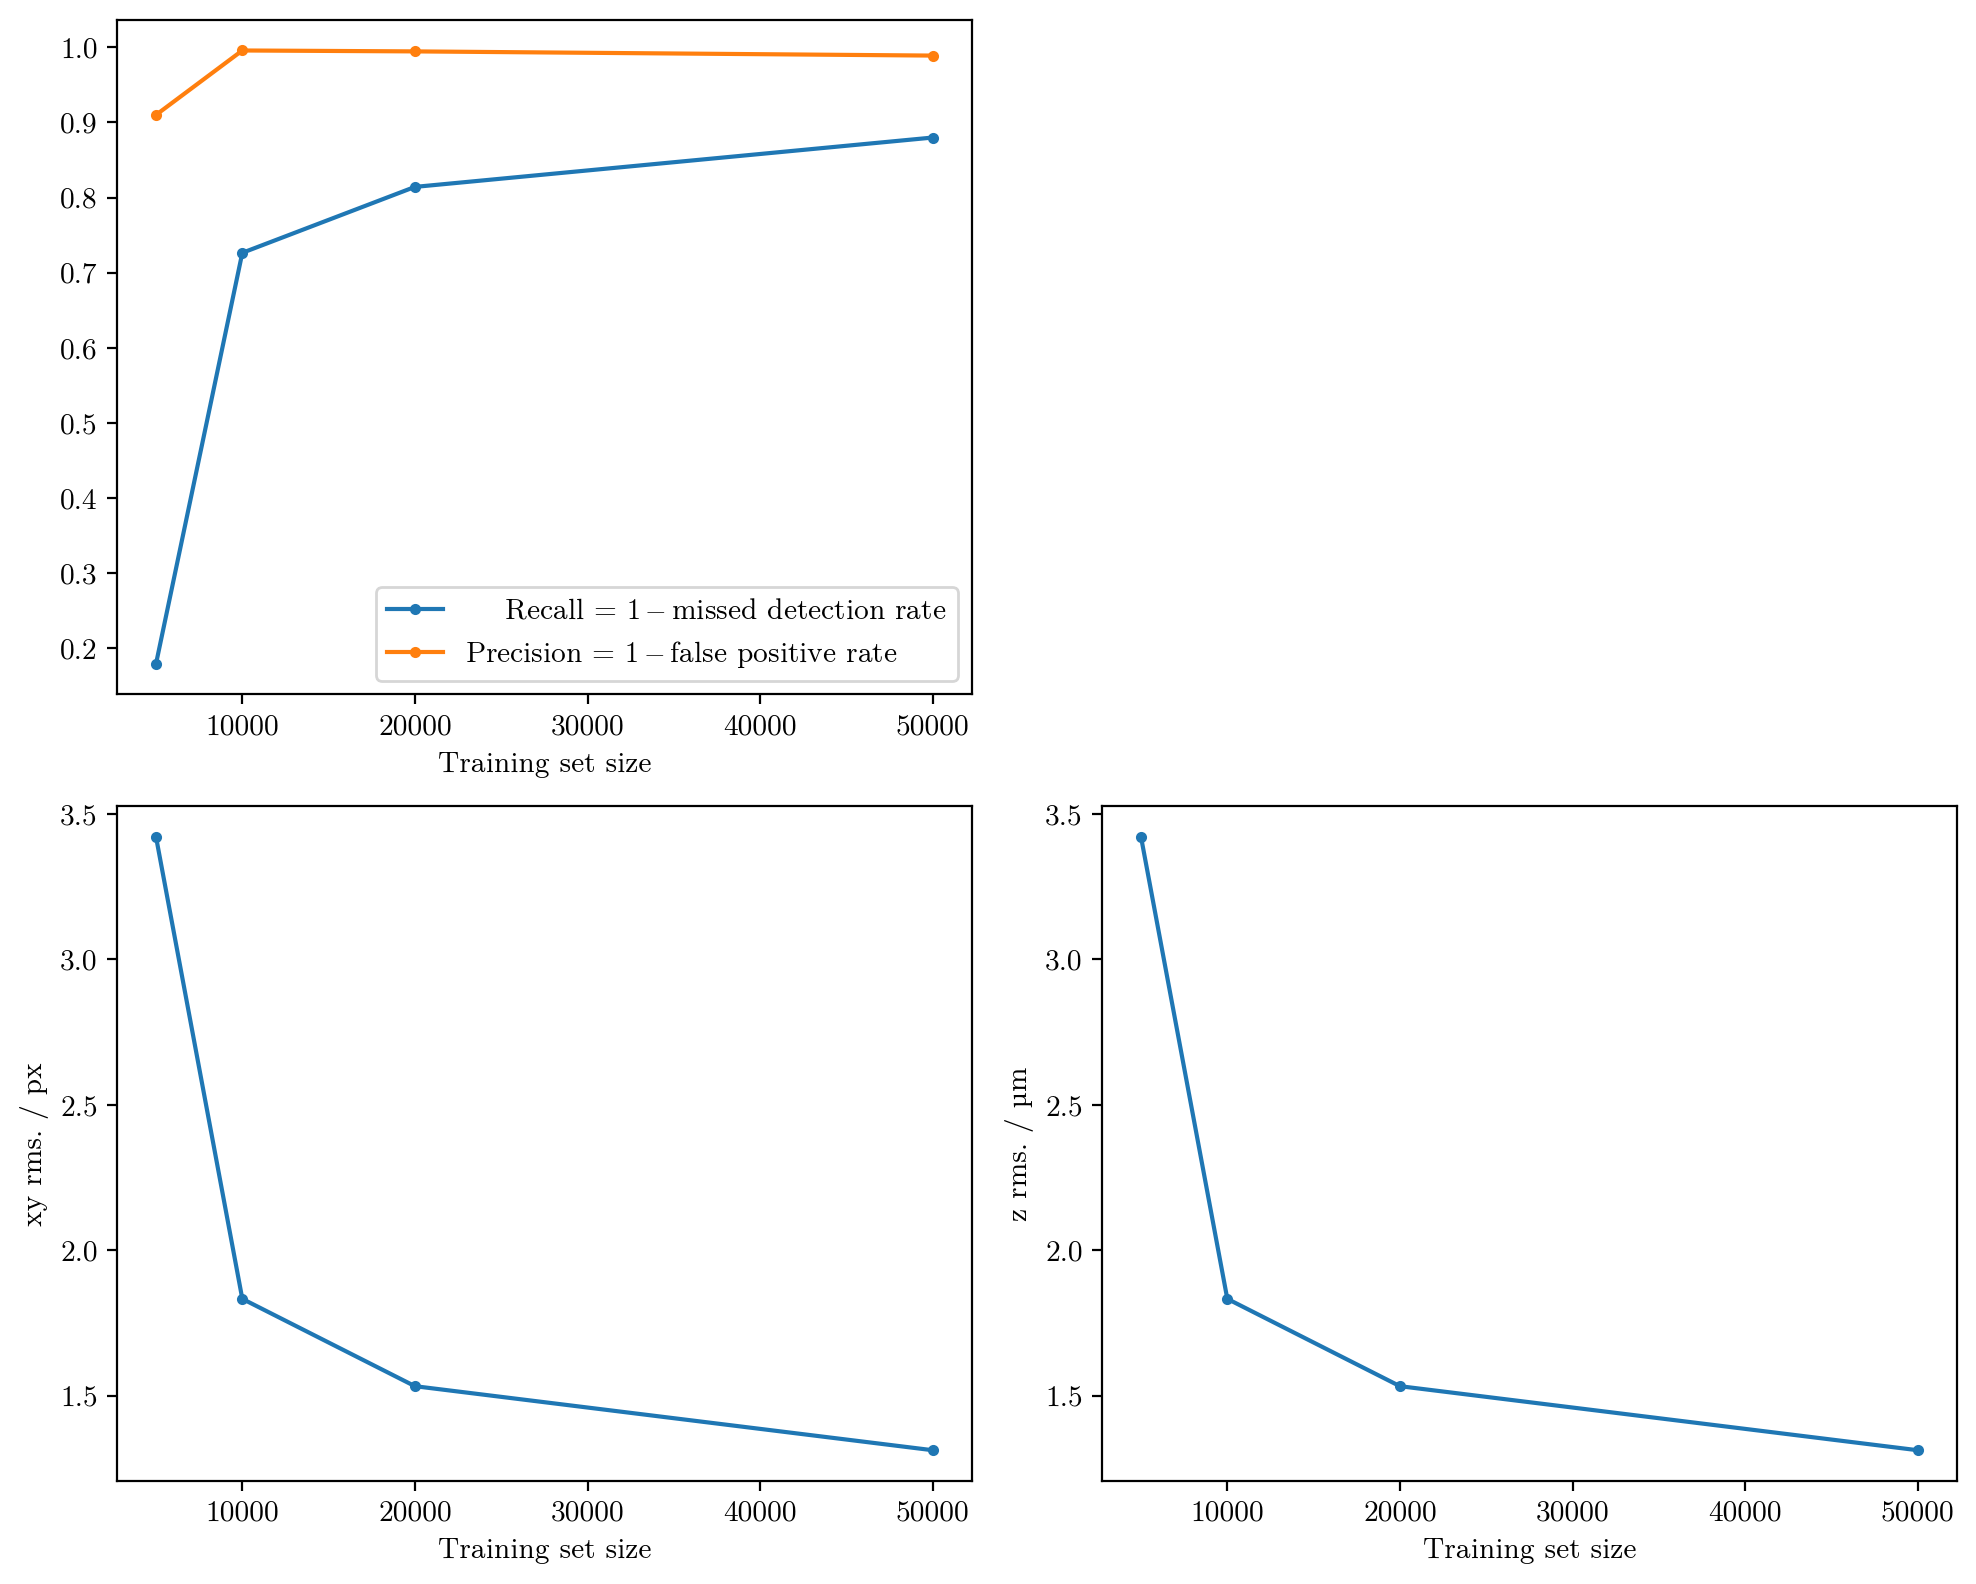

In [6]:

plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.xlabel("Training set size")
plt.plot(num, [res.box.r for res in results], ".-",label="    Recall = $1 -$missed detection rate")
plt.plot(num, [res.box.p for res in results], ".-",label="Precision = $1 -$false positive rate")
plt.legend()

plt.subplot(2,2,3)
#plt.axvline(45,0,1,ls="dashed", lw=0.9, label="training lower noise bound")
#plt.axvline(50,0,1,ls="dashed", lw=0.9, label="training upper noise bound")
# plt.axvline(47,0,1,ls="dashed", lw=0.9, label="yundon's noise level")
plt.plot(num, [res.xy_rms[6] for res in results], ".-",)
plt.xlabel("Training set size")
plt.ylabel("xy rms. / px")
plt.subplot(2,2,4)
#plt.axvline(45,0,1,ls="dashed", lw=0.9, label="training lower noise bound")
#plt.axvline(50,0,1,ls="dashed", lw=0.9, label="training upper noise bound")
# plt.axvline(47,0,1,ls="dashed", lw=0.9, label="yundon's noise level")
plt.plot(num, [res.xy_rms[6] for res in results], ".-",)


plt.xlabel("Training set size")
plt.ylabel("z rms. / µm")
plt.tight_layout()
plt.show()


